# Read in the data

In [6]:
import pandas as pd
import numpy
import re
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [8]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [9]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [11]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [12]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [33]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

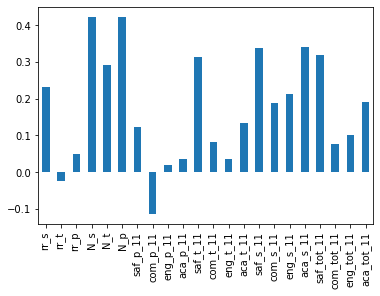

In [21]:
#Make a bar plot of the correlations between surveys and sat_score
combined.corr()["sat_score"][survey_fields].plot.bar()

In [ ]:
# There are high correlations between N_s, N_t, N_p and sat_score. It is intersting that aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.


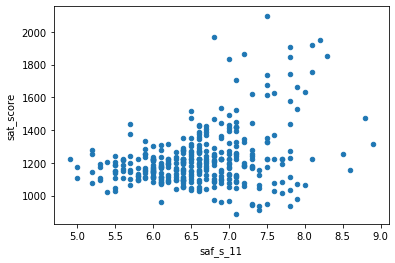

In [25]:
# Also we can see that students' and teachers' perception of safety correlates well with the SAT scores of a school. Let's investigate further.
combined.plot.scatter(x='saf_s_11', y='sat_score')

In [ ]:
# A step using Basemap module was omitted here due to difficulties with installation. 
# Instructions are:
#Map out safety scores.

#Compute the average safety score for each district.

#Make a map that shows safety scores by district.

#Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.

## Investigate Racial Differences in SAT Scores

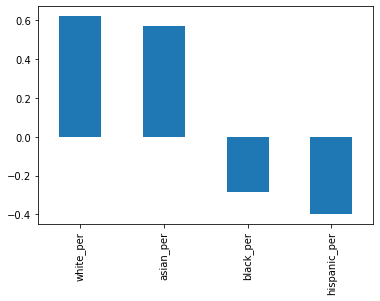

In [42]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][races].plot.bar()

In [ ]:
# We clearly see that white and asian races have much stronger correlations with SAT scores then black and hispanic. This suggests SAT might be a really unfair test to students of these races.

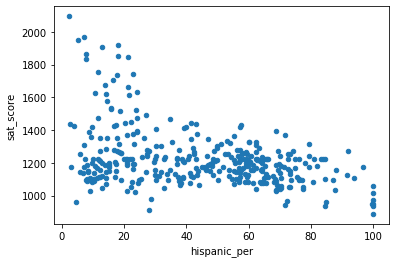

In [43]:
# Let's have a more detailed look at schools with high percentage of hispanic students and low SAT scores.
combined.plot.scatter(x='hispanic_per', y='sat_score')

In [44]:
# The scatter plot shows good negative correlation. The smaller the percentage of hispanic students in a school, the higher the SAT score.
# Let's research schools with a percentage of hispanic students greater than 95%
print(combined['SchoolName'][combined['hispanic_per']>95])

44             Manhattan Bridges High School
82                                         0
89            GREGORIO LUPERON HS SCI & MATH
125      Academy for Language and Technology
141    International School for Liberal Arts
176                                        0
253                Multicultural High School
286                                        0
Name: SchoolName, dtype: object


In [ ]:
# The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

## Investigate gender differences in SAT scores

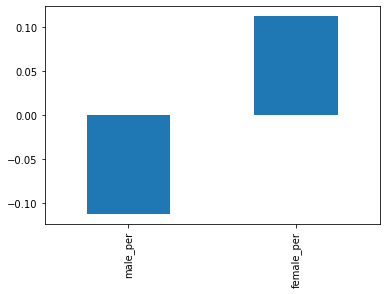

In [27]:
genders = ['male_per', 'female_per']
combined.corr()['sat_score'][genders].plot.bar()

In [ ]:
# Both male percentage and female percentage of students in a school have weak correlations with SAT scores. However, female percentage is in positive correlation and male perc. is in negative correlation. This suggests to some extent that the higher the SAT in a school, the smaller is the percentage of male students in that school.

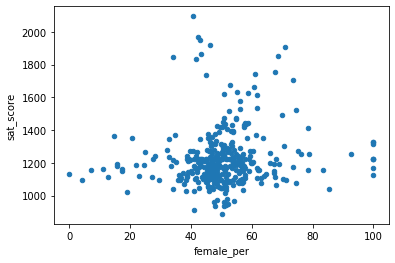

In [28]:
# Investigate schools with high SAT scores and a high female percentage
combined.plot.scatter(x='female_per', y='sat_score')

In [ ]:
# Scatter plot shows some weak correlation between the two variables. We can see that our previous claim is not necessarily correct since schools with high female percentages (>60%) are performing on the same level as those with lower percentages.

In [41]:
# There is a cluster of schools that have high SAT scores with female percentages around 60% - 80%. Let's look at their names and research them online.
print(combined[['SchoolName','female_per']][(combined['female_per'] > 60) & (combined['sat_score'] > 1700)])

SchoolName  female_per
5                                0        68.7
26   Eleanor Roosevelt High School        67.5
60                   BEACON SCHOOL        61.0
61         FIORELLO H.LAGUARDIA HS        73.6
302             TOWNSEND HARRIS HS        71.1


In [ ]:
#These schools appear to be very selective liberal arts schools that have high academic standards.

## AP Test Takers and SAT Scores

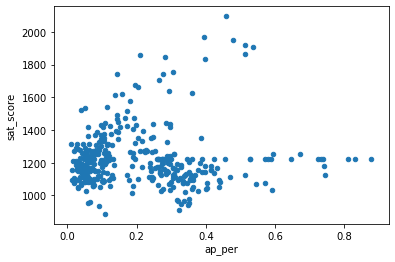

In [48]:
# First, calculate the percentage of students in each school that took an AP exam. Creating a new "ap_per" column with percentage of students who took AP tests in a school will help.
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

In [ ]:
# We would expect the two variables to hava strong correlation, since students taking AP exams are likely to perform better at the SAT tests. Weirdly, we observe weak correlation.

## Further Work on This Project


## Class Size and SAT Scores


mpl_toolkit.Basemap to plot locations of schools on the map